# Short Lab 3 : Proximal/cyclic/greedy coordinate descent

#### Authors: A. Gramfort, H. Janati, M. Massias

## Aim

The aim of this material is to code 
- cyclic and greedy coordinate descent for ordinary least squares (OLS)
- proximal coordinate descent for sparse Logistic regression

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 22nd of novemyer at noon**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "marius"
ln1 = "ortega"
fn2 = "wiam"
ln2 = "adnan"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab3", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab3_ortega_marius_and_adnan_wiam.ipynb


In [2]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

In [3]:
# the usual functions:

from numpy.random import multivariate_normal
from scipy.linalg import toeplitz
from numpy.random import randn

def simu(coefs, n_samples=1000, corr=0.5, for_logreg=False):
    n_features = len(coefs)
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    b = A.dot(coefs) + randn(n_samples)
    if for_logreg:
        b = np.sign(b)
    return A, b

## Part 1: Ordinary Least Squares


Let $A \in \mathbb{R}^{n \times p}$, $y \in \mathbb{R}^n$.
We want to use coordinate descent to solve:
    $$\hat w \in  \mathrm{arg \, min \,} \frac 12 \Vert Aw - b \Vert ^2 $$


<div class="alert alert-success">
    <b>QUESTION 1:</b> We ask you to code
     <ul>
         <li>cyclic coordinate descent: at iteration $t$, update feature $j = t \mod p$</li>
         <li>greedy coordinate descent: at iteration $t$, update feature having the largest partial gradient in magnitude, ie $j = \mathrm{arg\, max \,}_{i} \vert \nabla_i f(w_t) \vert$.
</li>
    </ul>
</div>

**WARNING**: You must do this in a clever way, ie such that $p$ updates cost the same as one update of GD.

In [4]:
n_features = 100
np.random.seed(1970)
coefs = np.random.randn(n_features)

A, b = simu(coefs, n_samples=1000, for_logreg=False)

In [5]:
def cyclic_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    w = np.zeros(n_features)
    residuals = b - A.dot(w)
    
    # TODO
    lips_const = np.linalg.norm(A, axis=0) ** 2
    # END TODO
    
    for t in range(n_iter):
        j = t % n_features
        # TODO
        old_w_j = w[j]
        w[j] += (1 / lips_const[j]) * A[:, j].dot(residuals)
        # update residuals:
        residuals += A[:, j] * (old_w_j - w[j])
        # END TODO
        
        if t % n_features == 0:
            all_objs.append((residuals ** 2).sum() / 2.)
    return w, np.array(all_objs)



def greedy_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    w = np.zeros(n_features)
    
    gradient = A.T.dot(A.dot(w) - b)
    gram = A.T.dot(A)  # you will need this to keep the gradient up to date
    
    # TODO
    lips_const = np.linalg.norm(A, axis=0) ** 2
    # END TODO 
    
    for t in range(n_iter):
        # TODO
        # choose feature j to update: 
        j = np.argmax(np.abs(gradient)) 
        old_w_j = w[j] 
        w[j] -= (1 / lips_const[j]) * gradient[j] 
        # update gradient:
        gradient += gram[:, j].dot(w[j] - old_w_j) 
        # END TODO
        if t % n_features == 0:
            all_objs.append(0.5 * np.linalg.norm(A.dot(w) - b) ** 2)
    
    return w, np.array(all_objs)

<div class="alert alert-success">
    <b>QUESTION 2:</b>
     <ul>
         <li>Compute a precise minimum with your favorite solver</li>
         <li>Compare the performance of cyclic and greedy CD as function of iterations.</li>
         <li>From a practical point of view, could you use greedy CD for L2 regularized logistic regression? to solve OLS, but with 100,000 features? Explain your answers.</li>
    </ul>
</div>

**Remark:** You will do the plots using the number of iterations on the x-axis and not time as your code is likely to be slow unless you use [numba](https://numba.pydata.org/).

#### Compute a precise minimum with your favorite solver

In [6]:
w_cyclic, objs_cyclic = cyclic_cd(A, b, 1000)
w_greedy, objs_greedy = greedy_cd(A, b, 1000)

In [7]:
print("Cyclic method precise minimum: ", objs_cyclic[-1], "\nGreedy method precise minimum: ", objs_greedy[-1])

Cyclic method precise minimum:  466.8214910481989 
Greedy method precise minimum:  466.39263263504773


#### Compare the performance of cyclic and greedy CD as function of iterations

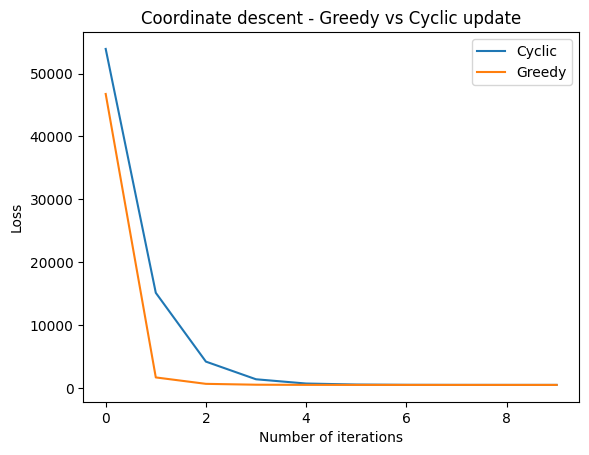

In [8]:
plt.plot(objs_cyclic, label="Cyclic")
plt.title('Loss Evolution')
plt.plot(objs_greedy, label="Greedy")
plt.title('Coordinate descent - Greedy vs Cyclic update')
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

From the above plot, we can see that greedy CD converges faster than cyclic CD in terms of iterations.

#### From a practical point of view, could you use greedy CD for L2 regularized logistic regression? to solve OLS, but with 100,000 features? Explain your answers.

* Greedy CD for L2 regularized logistic regression : 

    The loss function of such problem is given by :
    $$\hat w \in  \mathrm{arg \, min \,} \frac 12 \Vert Aw - b \Vert ^2 + \lambda \Vert w \Vert^2_2$$

    The minimization problem is convex (local minimum = global minimum) and differentiable (gradient exists everywhere) because it is quadratic as being the sum of two quadratic functions. Consequently, the gradient is Lipschitz continuous and we can use the greedy CD algorithm without any modification.

* Greedy CD for OLS with 100,000 features :
    
    On the plot above, we notice that iteration-wise the greedy CD algorithm is faster than the cyclic CD algorithm. However, the greedy CD algorithm is more expensive in terms of computation time. Indeed, Greedy CD requires to compute the whole gradient at each iteration in order to select the coordinate with the largest partial gradient in magnitude. This is not the case for cyclic CD. 
    
    Consequently, in order to keep the strong convexity of the problem for a large number of features ($n_{samples} \gg n_{features}$), we would requires a number of samples far greater than 100 000. Consequently, the greedy CD algorithm wouldn't not suitable as its implementation in inherently slower than cyclic CD for instance, hence not adapted for datasets with a large number of samples.


## Part 2: Sparse Logistic regression

### An important result

Remember: we are solving 
$$\hat w \in \mathrm{arg \, min} \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1$$

<div class="alert alert-success">
    <b>QUESTION 3:</b><br/>
    Assuming uniqueness of the solution, show that: $\lambda \geq \lambda_{max} \Leftrightarrow \hat w = 0$
where $\lambda_{max} := \frac 12 \Vert X^\top y \Vert_{\infty}$.
</div>

Assuming uniqueness of the solution, show that: $\lambda \geq \lambda_{max} \Leftrightarrow \hat w = 0$
where $\lambda_{max} := \frac 12 \Vert X^\top y \Vert_{\infty}$.

**HINT:** You will need the following beautiful result: for any $w =(w_1, \dots, w_p) \in \mathbb{R}^p$, the subdifferential of the L1 norm at $w$ is:

$$
\partial \Vert \cdot \Vert_1 (w) = \partial \vert \cdot \vert (w_1)  \times \dots \times \partial \vert \cdot \vert (w_p) $$
where $\times$ is the Cartesian product between sets, and 

$$ 
\partial \vert \cdot \vert (w_j) = 
\begin{cases} &w_j / |w_j| &\mathrm{if} \quad w_j \neq 0, 
         \\ & [-1, 1] &\mathrm{otherwise.} 
\end{cases}
$$


it should now be easy to find $\partial \Vert \cdot \Vert_1 (\mathbf{0}_p)$

#### 1. Problem Rewritting

Let : 
$$
\begin{cases}
f(w) = \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} ) \\
g(w) = \lambda \Vert w \Vert_1
\end{cases}
$$

Consequently, we can rewrite the problem as :
$$
\hat w \in \mathrm{arg \, min} \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1 = \mathrm{arg \, min} f(w) + g(w)
$$

#### 2.Optimality condition

Letrs write the derivative of f and g :
$$
\begin{cases}
\partial f(w) = \sum_{i=1}^{n} \frac{-y_i x_i e^{- y_i w^\top x_i}}{1 + e^{- y_i w^\top x_i}} = \sum_{i=1}^{n} -y_ix_i (1- \sigma (y_i w^\top x_i))\\
\partial g(w) = \lambda \partial \Vert \cdot \Vert_1 (w)
\end{cases}
$$

We can now write the optimality condition :
$$
0 \in \partial f(w) + \partial g(w) \Rightarrow 0 \in \sum_{i=1}^{n} -y_ix_i (1- \sigma (y_i w^\top x_i)) + \lambda \partial \Vert \cdot \Vert_1 (w)
$$

#### 3. Proof

##### Implication : $\hat w = 0 \Rightarrow \lambda \geq \lambda_{max}$ 

If $\hat w = 0$, then $\partial \Vert \cdot \Vert_1 (\hat w) = \partial \Vert \cdot \Vert_1 (\mathbf{0}_p) = [-1, 1]^p$. Consequently, we have :
$$
\begin{align*}
& -\partial f(w) \ge \partial g(w) \Rightarrow \sum_{i=1}^{n} \frac{-y_i x_i }{2} \ge \lambda [-1, 1]^p \\
& \Rightarrow \lambda \ge \frac 12 \Vert X^\top y \Vert_{\infty} \\
& \Rightarrow \lambda \ge \lambda_{max}
\end{align*}
$$

##### Reciprocal : $\lambda \geq \lambda_{max} \Rightarrow \hat w = 0$

if $\lambda \geq \lambda_{max}$, then $\lambda \geq \frac 12 \Vert X^\top y \Vert_{\infty}$. Using identification method :

$$
\begin{cases}
\partial f(w) = \frac 12 \Vert X^\top y \Vert_{\infty} \\
\partial g(w) = \lambda [-1, 1]^p
\end{cases}
\Rightarrow 
w=0, \text{Considering the uniqueness of the solution}
$$

##### Conclusion
The implication and the reciprocal are true, so we can conclude that :
$$
\lambda \geq \lambda_{max} \Leftrightarrow \hat w = 0
$$

<div class="alert alert-success">
    <b>QUESTION 4:</b><br/>
    Show that for sparse Logistic regression the coordinate-wise Lipschitz constant of the smooth term, $\gamma_j$, can be taken equal to $\Vert X_j \Vert^2 / 4$, where $X_j$ denotes the $j$-th column of $X$.
</div>

Show that for sparse Logistic regression the coordinate-wise Lipschitz constant of the smooth term, $\gamma_j$, can be taken equal to $\Vert X_j \Vert^2 / 4$, where $X_j$ denotes the $j$-th column of $X$.

Here, we will use 2nd order smoothness definition :
$$
\nabla^2 f(x) \preceq L \times I_d
$$

We first compute the Hessian our smooth function $f$ :

$$
\begin{align*}

& f(w) = \sum_{i=1}^{n} \log(1 + e^{-y_i w^\top x_i}) \\ 
& \frac{\partial f(w)}{\partial w_j} = \sum_{i=1}^{n} \frac{-y_i x_{ij} e^{-y_i w^\top x_i}}{1 + e^{-y_i w^\top x_i}} \\

    
& \frac{\partial^2 f(w)}{\partial w_j^2} = \sum_{i=1}^{n} \left[ \frac{y_i^2 x_{ij}^2 e^{-y_i w^\top x_i}}{(1 + e^{-y_i w^\top x_i})^2} - \frac{y_i x_{ij} (-y_i x_{ij}) e^{-y_i w^\top x_i}}{(1 + e^{-y_i w^\top x_i})} \right] = \sum_{i=1}^{n} \frac{x_{ij}^2 e^{-y_i w^\top x_i}}{(1 + e^{-y_i w^\top x_i})^2} \text{ As } y_i^2 = 1 \text{ because } y_i \in \{-1, 1\}\\
& \frac{\partial^2 f(w)}{\partial w_j^2} = \sum_{i=1}^{n} \frac{x_{ij}^2 e^{-y_i w^\top x_i}}{(1 + e^{-y_i w^\top x_i})^2} \le \sum_{i=1}^{n} \frac{x_{ij}^2}{4} = \frac{1}{4} \Vert X_j \Vert^2

\end{align*}
$$

Then, we compute the Hessian for our regularizer $g$ :

$$
\begin{align*}

& g(w) = \lambda \Vert w \Vert_1 \\
& \nabla g(w) = \lambda \partial \Vert \cdot \Vert_1 (w) =
    \begin{cases}
        & \lambda sign(w_j) &\mathrm{if} \quad w_j \neq 0 \\ 
        & [-\lambda, \lambda] &\mathrm{otherwise.}
    \end{cases} \\
& \nabla^2 g(w) = 0

\end{align*}
$$

We can now conclude that :

$$
\frac{\partial^2}{\partial w_j^2} (f + g)(w) = \frac{\partial^2}{\partial w_j^2} f(w) + \frac{\partial^2}{\partial w_j^2} g(w) \preceq \frac{1}{4} \Vert X_j \Vert^2
$$

$$
\gamma_j = \frac{1}{4} \Vert X_j \Vert^2
$$

<div class="alert alert-success">
    <b>QUESTION 5:</b><br/>
    Code cyclic proximal coordinate descent for sparse Logistic regression:
</div>

**WARNING**: the Lasso means linear regression (quadratic fitting term) with L1 penalty. Sparse logistic regression means logistic regression with L1 penalty.

In [9]:
X, y = simu(coefs, n_samples=1000, for_logreg=True)
lambda_max = norm(X.T.dot(y), ord= np.inf) / 2.
lamb = lambda_max / 20.
# much easier to parametrize lambda as a function of lambda_max than 
# to take random values like 0.1 in previous Labs


def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))


def soft_thresh(x, u):
    """Soft thresholding of x at level u"""
    return np.sign(x) * np.maximum(0., np.abs(x) - u)


def cd_logreg(X, y, lamb, n_iter):
    n_samples, n_features = X.shape
    all_objs = np.zeros(n_iter)
    w = np.zeros(n_features)
    Xw = X.dot(w)
    
    # TODO
    lips_const = 0.25 * norm(X, axis=0, ord=2)**2
    step = 1 / lips_const
    # END TODO
    
    for t in range(n_iter):
        for j in range(n_features):
            old_w_j = w[j]
            # TODO
            sigmoid_xw = sigmoid(y * Xw)
            grad_j = -np.sum(y * X[:, j] * (1 - sigmoid_xw))
            w[j] = soft_thresh(old_w_j - grad_j * step[j], lamb *step[j])
   
            if old_w_j != w[j]:
                Xw += X[:, j].dot(w[j] - old_w_j)
            #END TODO
            
        all_objs[t] = np.log(1. + np.exp(-y * Xw)).sum() + lamb * norm(w, ord=1)
    
    return w, all_objs

In [10]:
cd_logreg_w, cd_logreg_objs = cd_logreg(X, y, lamb, 150)

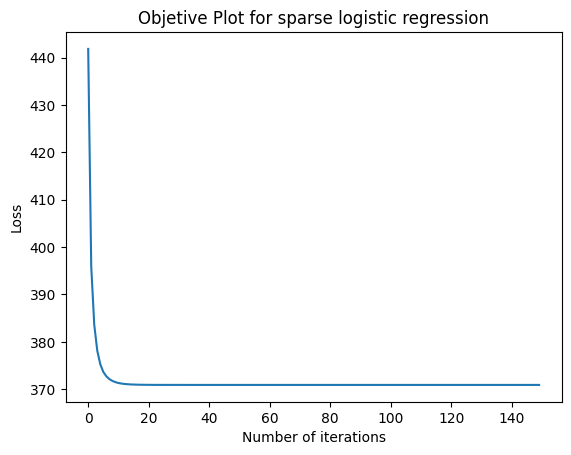

In [11]:
plt.plot(cd_logreg_objs)
plt.title('Objetive Plot for sparse logistic regression')
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.show()

# Part 3: Real data

We will compare vanilla cyclic CD and ISTA to solve the Lasso on a real dataset, called _leukemia_.

In [12]:
from sklearn.datasets import fetch_openml

leuk = fetch_openml("leukemia")

X = np.asfortranarray(leuk.data)
y = np.ones(leuk.target.shape)
y[leuk.target == leuk.target[0]] = -1.

c:\Pro\Cours\A5 - IPP\Optimization for Data Science\Labs\optim_venv\Lib\site-packages\sklearn\datasets\_openml.py:311: UserWarning: Multiple active versions of the dataset matching the name leukemia exist. Versions may be fundamentally different, returning version 1.
  warn(
c:\Pro\Cours\A5 - IPP\Optimization for Data Science\Labs\optim_venv\Lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [13]:
print(X.shape)

lambda_max_lasso = norm(X.T.dot(y), ord=np.inf)
lambd = lambda_max_lasso / 5.

print("L_max: ", lambda_max_lasso, "\nLambda: ", lambd)

(72, 7129)
L_max:  588514.0 
Lambda:  117702.8


<div class="alert alert-success">
    <b>QUESTION 6:</b> Code
    <ul>
        <li>a simple proximal gradient solver for the Lasso</li>
        <li>a prox CD solver for the Lasso and compare them on this dataset.</li>
    </ul>
</div>

**Remark:** Do the plots in terms of epochs, not updates (to be fair to CD).

#### Simple proximal gradient solver for the Lasso

In [14]:
def smoothness_const_linreg(X):
    """Lipschitz constant for linear squares loss"""
    return norm(X, ord=2)**2

def loss_linreg(X, y, x):
    """Least-squares loss"""
    loss = 0.5 * norm(y - X@x, ord=2)**2
    return loss

def grad_linreg(X, y, x):
    """Leas-squares gradient"""
    grad = X.T @ (X@x - y)
    return grad

def prox_L1(x, lmbd):
    """Proximal operator for the L1 at x"""
    return np.sign(x) * np.maximum(np.abs(x) - lmbd, 0)

def L1_norm(x, lmbd):
    """Value of the L1 penalization at x"""
    return lmbd * norm(x, ord=1)

def PGD(X, y, x0, f, grad_f, R, prox_R, step, lmbd=0., n_iter=50, x_true=None, verbose=False):
    """Proximal gradient descent algorithm"""
    x = x0.copy()
    x_new = x0.copy()

    # objective history
    objectives = []
    # Current objective
    obj = f(X, y, x) + R(x, lmbd)
    objectives.append(obj)

    if verbose:
        print("Lauching PGD solver...")
        headers = ["it", "obj"]
        print(' | '.join([name.center(8) for name in headers]))
    for k in range(n_iter + 1):
        x_new = prox_R(x - step * grad_f(X, y, x), lmbd * step)
        x = x_new
        obj = f(X, y, x) + R(x, lmbd)
        objectives.append(obj)

        if k % 10 == 0 and verbose:
            output = [("%d" % k).rjust(8), ("%.2e" % obj).rjust(8)]
            print(' | '.join(output))
    return x, objectives

In [15]:
step = 1 / smoothness_const_linreg(X)
x0 = np.zeros(X.shape[1])
n_iter = 1000
lmbd = lambd

x_pgd, objs_pgd = PGD(x0 = x0,
                      f = loss_linreg,
                      grad_f = grad_linreg,
                      R = L1_norm,
                      prox_R = prox_L1,
                      step = step,
                      lmbd = lambd,
                      n_iter = n_iter,
                      X=X, 
                      y=y,
                      verbose = False,
)

[]

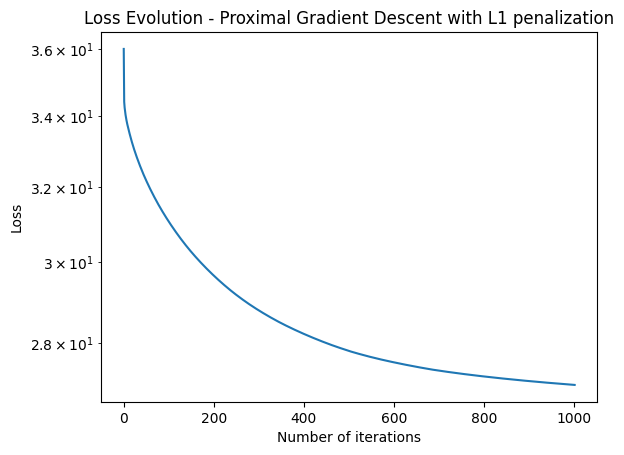

In [16]:
plt.plot(objs_pgd, label="CD")
plt.title('Loss Evolution - Proximal Gradient Descent with L1 penalization')
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.semilogy()

#### Prox CD solver for the Lasso

In [17]:
def grad_j_linreg(Xj, Xw, y): 
    grad_j = Xj@(Xw - y)  
    return grad_j

def f(w, X, y):
    return 0.5 * norm(y - X.dot(w), ord=2)**2

def smoothness_const_linreg_CD(X):
    """Lipschitz constant for linear squares loss"""
    return norm(X, axis=0, ord=2)**2

def PCD(X, y, f, grad_i, R, prox_R, step, lmbd, n_iter, verbose=True):
    """Proximal coordinate descent algorithm"""
    
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    Xw = X.dot(w)
    
    # objective history
    objectives = []
    
    # Current objective
    obj = f(w, X, y) + R(w, lmbd)
    objectives.append(obj)
    
    if verbose:
        print("Lauching PCD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj"]]))
    
    for t in range(n_iter):
        for j in range(n_features): # to make PCD computation fair with PGD's (epoch-wise)
        
            old_w_j = w[j]
            grad_j = grad_i(X[:, j], Xw, y)
            w[j] = prox_R(w[j] - grad_j*step[j] , lmbd*step[j])
            if old_w_j != w[j]:
                Xw += X[:, j].dot(w[j] - old_w_j)
    
        obj = f(w, X, y) + R(w, lmbd)
        objectives.append(obj)
        
        if t % 10 == 0 and verbose:
            output = [("%d" % t).rjust(8), ("%.2e" % obj).rjust(8)]
            print(' | '.join(output))

    return w, np.array(objectives)

In [18]:
# prox CD for lasso
w_min_PCD, obj_PCD = PCD(X, 
                         y,
                         f, 
                         grad_j_linreg, 
                         L1_norm, 
                         prox_L1, 
                         1/smoothness_const_linreg_CD(X), 
                         lambd, 
                         1000, 
                         verbose=False)

[]

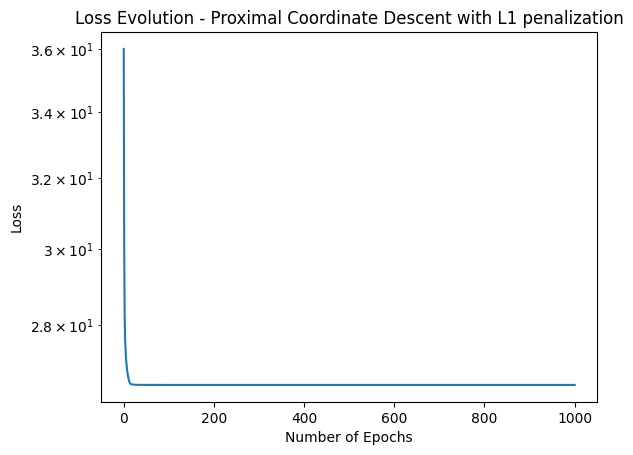

In [19]:
plt.plot(obj_PCD, label="PCD")
plt.title('Loss Evolution - Proximal Coordinate Descent with L1 penalization')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.semilogy()

#### Comparison between the two solvers (in terms of epochs)

[]

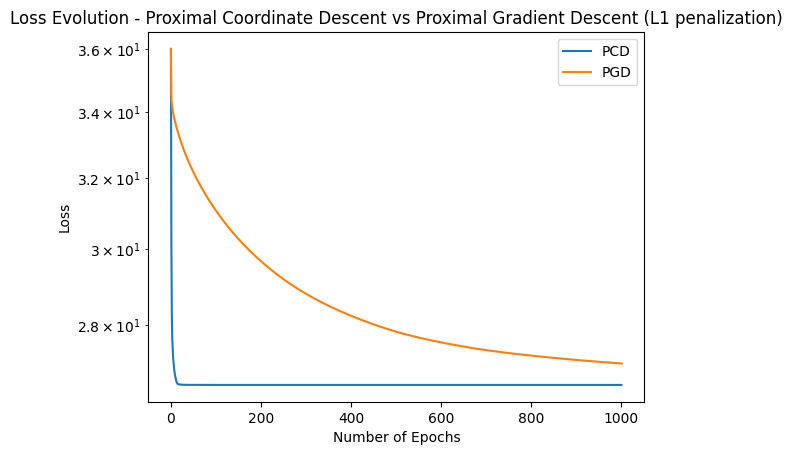

In [20]:
plt.plot(obj_PCD, label="PCD")
plt.plot(objs_pgd, label="PGD")
plt.title('Loss Evolution - Proximal Coordinate Descent vs Proximal Gradient Descent (L1 penalization)')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.semilogy()

From looking at the output of both solvers, we denote that the proximal coordinate descent algorithm is faster than the proximal gradient descent algorithm in terms of epochs. 

This can be explained by many things :
* Variable correlation : classical gradient descent performs very poorly on correlated data (as seen in the lab 2). Coordinate descent is less sensitive to this problem as it updates only one variable at a time.
* Variable scaling : classical gradient descent performs very poorly on data with different scales. In fact, PGD has only 1 value of $L$ for all variables while PCD has a different $L$ for each variable. Consequently, PCD is less sensitive to this problem as it updates each each variable parameter with respect to its own Lipschitz constant $\gamma_j$, thus taking into account its scale. From the sparsity point of view (as we are using lasso), the fact that Proximal Coordinate Descent updates each individual $w_j$ with respect to its scaling promotes sparsity in a more efficient way than Proximal Gradient Descent.